In [3]:
import pandas as pd
import numpy as np
import torch
import pickle
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModel

from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

C:\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [4]:
df = pd.read_csv('../data/law_url_vec.csv')
df

,title,url,category,vector
0,헌법재판소 사무기구에 관한 규칙,https://likms.assembly.go.kr/law/lawsLawtInqyD...,헌 법,"[-0.3515315353870392, -0.9978629946708679, 0.0..."
1,헌법재판소 공무원 규칙,https://likms.assembly.go.kr/law/lawsLawtInqyD...,헌 법,"[-0.35523107647895813, -0.7502918243408203, 0...."
2,헌법재판소 공무원 평정 규칙,https://likms.assembly.go.kr/law/lawsLawtInqyD...,헌 법,"[-0.53923499584198, -0.7991077303886414, 0.410..."
3,공직자윤리법의 시행에 관한 헌법재판소 규칙,https://likms.assembly.go.kr/law/lawsLawtInqyD...,헌 법,"[-0.33975574374198914, -0.6929662227630615, -0..."
4,평화경제특별구역의 지정 및 운영에 관한 법률 시행령,https://likms.assembly.go.kr/law/lawsLawtInqyD...,헌 법,"[-0.6999249458312988, -0.5856434106826782, 0.3..."
...,...,...,...,...
6615,물품세법등중개정법률,https://likms.assembly.go.kr/law/lawsLawtInqyD...,기타,"[-0.5172092318534851, -0.037322286516427994, 0..."
6616,교육법실시에따르는현존학교에관한조치령,https://likms.assembly.go.kr/law/lawsLawtInqyD...,기타,"[-0.1838398277759552, -0.1500200778245926, 0.6..."
6617,농림부직제및상공부직제중개정의건,https://likms.assembly.go.kr/law/lawsLawtInqyD...,기타,"[-0.5259078741073608, -0.11932042986154556, 0...."
6618,광업에관한제수수료에관한건,https://likms.assembly.go.kr/law/lawsLawtInqyD...,기타,"[0.0691865012049675, -0.6437087655067444, 0.12..."


# TFIDF
유사도가 0.5 이상인 것만 출력되도록 설정

In [5]:
texts = df['title'].tolist()

In [6]:
tokenizer = Okt()

def tokenize_ko(x):
    x = tokenizer.normalize(x) # 텍스트 Normalization
    x = tokenizer.morphs(x) # 형태소 분리
    return x

In [7]:
# TfidfVectorizer 객체 생성 ( 토크나이저로 형태소 분석기 사용)
vectorizer = TfidfVectorizer(tokenizer=tokenize_ko)

# 텍스트 데이터를 벡터 형태로 변환
tfidf_matrix = vectorizer.fit_transform(texts)

C:\Users\82102\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [8]:
def extract_tfidf(new_text, tfidf_matrix): # new_text : 문자열
    # 새로운 문장을 벡터 형태로 변환
    new_tfidf_vector = vectorizer.transform([new_text])

    # 새로운 문장과 기존 문장들 사이의 코사인 유사도 계산
    cosine_similarities = cosine_similarity(new_tfidf_vector, tfidf_matrix)

    # 새로운 문장과 기존 문장을 비교하여 유사도를 출력
    print(f"추출된 법률: {new_text}")
    print('-'*75)
    print(f"유사도 0.5 이상의 기존 법률:")
    
    idx_list = []
    for idx in range(5):
        most_similar_idx = cosine_similarities.argsort()[0][(idx+1)*-1]
        
        most_similar_sentence = texts[most_similar_idx]
        similarity_score = cosine_similarities[0][most_similar_idx]
        if similarity_score > 0.5:
            idx_list.append(most_similar_idx)
            print(f"{most_similar_sentence} (유사도: {similarity_score:.4f})")

    return idx_list

In [9]:
idices = extract_tfidf('형사사법절차전자화촉진법', tfidf_matrix)

추출된 법률: 형사사법절차전자화촉진법
---------------------------------------------------------------------------
유사도 0.5 이상의 기존 법률:
형사사법절차 전자화 촉진법 (유사도: 1.0000)


In [10]:
df.iloc[idices]

,title,url,category,vector
324,형사사법절차 전자화 촉진법,https://likms.assembly.go.kr/law/lawsLawtInqyD...,행정일반,"[-0.2244352549314499, -0.45357635617256165, 0...."


In [11]:
idices = extract_tfidf('중대재해법', tfidf_matrix)

추출된 법률: 중대재해법
---------------------------------------------------------------------------
유사도 0.5 이상의 기존 법률:
중대재해 처벌 등에 관한 법률 (유사도: 0.7728)
중대재해 처벌 등에 관한 법률 시행령 (유사도: 0.7523)


In [12]:
df.iloc[idices]

,title,url,category,vector
1094,중대재해 처벌 등에 관한 법률,https://likms.assembly.go.kr/law/lawsLawtInqyD...,형사법,"[-0.4381081759929657, -0.6883171200752258, 0.4..."
1081,중대재해 처벌 등에 관한 법률 시행령,https://likms.assembly.go.kr/law/lawsLawtInqyD...,형사법,"[-0.5815795063972473, -0.47542381286621094, 0...."


In [13]:
idices = extract_tfidf('개인정보보호법', tfidf_matrix) # 

추출된 법률: 개인정보보호법
---------------------------------------------------------------------------
유사도 0.5 이상의 기존 법률:


In [14]:
idices

[]

In [15]:
df.iloc[idices]

,title,url,category,vector


이렇게 띄어쓰기에 따라 인식이 되는경우, 안되는 경우가 있음.
-> 인식이 안될 경우 -> (jupyter)law_matching_SBERT 사용하자!!!!!

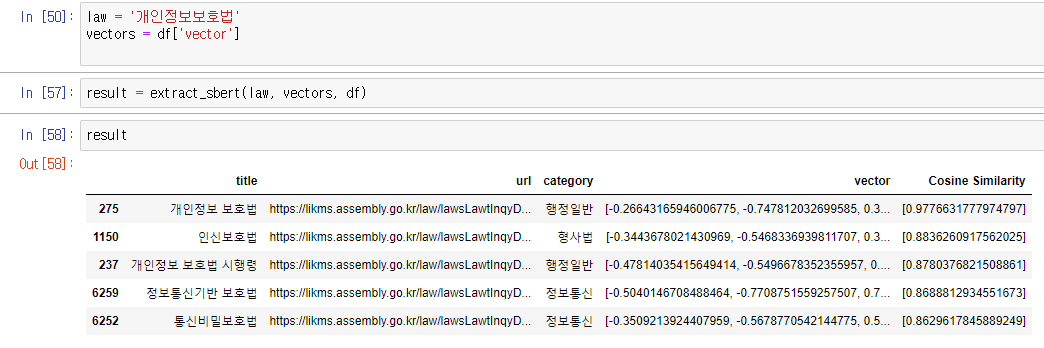

# SBERT

In [16]:
# Hugging Face의 Pretrained Language Model을 사용하여 문장을 벡터화
model_name = "bert-base-multilingual-cased"
tokenizer_bert = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [17]:
# 문장을 벡터화하는 함수
def sentence_to_vector(sentence):
    input_ids = tokenizer_bert.encode(sentence, add_special_tokens=True, truncation=True, padding="longest")
    inputs = np.array([input_ids])
    with torch.no_grad():
        outputs = model(torch.tensor(inputs))
    sentence_vector = np.mean(outputs.last_hidden_state.numpy(), axis=1)
    return sentence_vector

In [18]:
def cosine_similarity_sbert(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)
    similarity = dot_product / (norm_vector1 * norm_vector2)
    return similarity

def find_top5_similar_vectors(target_vector, vector_list):
    similarities = []

    for i, vector in enumerate(vector_list):
        similarity = cosine_similarity_sbert(target_vector, vector)
        similarities.append((i, similarity))

    # 상위 5개의 인덱스와 코사인 유사도를 추출
    top5_indices_and_sims = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]
    top5_indices = [index for index, _ in top5_indices_and_sims]
    top5_sims = [sim for _, sim in top5_indices_and_sims]
    return top5_indices, top5_sims

def extract_sbert(law, vectors, df):
    vec = sentence_to_vector(law)
    indices, similarities = find_top5_similar_vectors(vec, vectors)
    
    result_df = df.iloc[indices].copy()
    result_df['Cosine Similarity'] = similarities  # Add a new column for cosine similarities
    return result_df

In [19]:
import ast

# df['vector']의 각 원소를 문자열에서 리스트로 변환
df['vector'] = df['vector'].apply(ast.literal_eval)

In [20]:
law = '개인정보보호법'
vectors = df['vector']

In [21]:
result = extract_sbert(law, vectors, df)

In [22]:
result

,title,url,category,vector,Cosine Similarity
275,개인정보 보호법,https://likms.assembly.go.kr/law/lawsLawtInqyD...,행정일반,"[-0.26643165946006775, -0.747812032699585, 0.3...",[0.9776631777974797]
1150,인신보호법,https://likms.assembly.go.kr/law/lawsLawtInqyD...,형사법,"[-0.3443678021430969, -0.5468336939811707, 0.3...",[0.8836260917562025]
237,개인정보 보호법 시행령,https://likms.assembly.go.kr/law/lawsLawtInqyD...,행정일반,"[-0.47814035415649414, -0.5496678352355957, 0....",[0.8780376821508861]
6259,정보통신기반 보호법,https://likms.assembly.go.kr/law/lawsLawtInqyD...,정보통신,"[-0.5040146708488464, -0.7708751559257507, 0.7...",[0.8688812934551673]
6252,통신비밀보호법,https://likms.assembly.go.kr/law/lawsLawtInqyD...,정보통신,"[-0.3509213924407959, -0.5678770542144775, 0.5...",[0.8629617845889249]


# matching(TFIDF+SBERT)
 
- 유사도 0.5이상인 법률이 없을 경우 SBERT를 통한 방법 사용


In [23]:
law = '개인정보보호법'
# tfidf_matrix = vectorizer.fit_transform(texts)
# vectors = df['vector']
# df = pd.read_csv('../data/law_url_vec.csv')

In [24]:
def matching(law, tfidf_matrix, vectors, df):
    idices = extract_tfidf(law, tfidf_matrix)
    if not idices:
        result = extract_sbert(law, vectors, df)
    else:
        result = df.iloc[idices]
    return result

In [25]:
result = matching(law, tfidf_matrix, vectors, df)

추출된 법률: 개인정보보호법
---------------------------------------------------------------------------
유사도 0.5 이상의 기존 법률:


In [26]:
result

,title,url,category,vector,Cosine Similarity
275,개인정보 보호법,https://likms.assembly.go.kr/law/lawsLawtInqyD...,행정일반,"[-0.26643165946006775, -0.747812032699585, 0.3...",[0.9776631777974797]
1150,인신보호법,https://likms.assembly.go.kr/law/lawsLawtInqyD...,형사법,"[-0.3443678021430969, -0.5468336939811707, 0.3...",[0.8836260917562025]
237,개인정보 보호법 시행령,https://likms.assembly.go.kr/law/lawsLawtInqyD...,행정일반,"[-0.47814035415649414, -0.5496678352355957, 0....",[0.8780376821508861]
6259,정보통신기반 보호법,https://likms.assembly.go.kr/law/lawsLawtInqyD...,정보통신,"[-0.5040146708488464, -0.7708751559257507, 0.7...",[0.8688812934551673]
6252,통신비밀보호법,https://likms.assembly.go.kr/law/lawsLawtInqyD...,정보통신,"[-0.3509213924407959, -0.5678770542144775, 0.5...",[0.8629617845889249]


In [27]:
law = '달빛철도특별법'
# tfidf_matrix = vectorizer.fit_transform(texts)
# vectors = df['vector']
# df = pd.read_csv('../data/law_url_vec.csv')

In [28]:
result = matching(law, tfidf_matrix, vectors, df)

추출된 법률: 달빛철도특별법
---------------------------------------------------------------------------
유사도 0.5 이상의 기존 법률:
철도안전법 (유사도: 0.6552)
철도사업법 (유사도: 0.6451)
철도안전법 시행규칙 (유사도: 0.6175)
철도의 건설 및 철도시설 유지관리에 관한 법률 (유사도: 0.6131)
철도안전법 시행령 (유사도: 0.6131)


In [29]:
result

,title,url,category,vector
5886,철도안전법,https://likms.assembly.go.kr/law/lawsLawtInqyD...,육운·항공·관광,"[-0.17733250558376312, -0.5263206362724304, 0...."
5870,철도사업법,https://likms.assembly.go.kr/law/lawsLawtInqyD...,육운·항공·관광,"[0.011703510768711567, -0.41449448466300964, 0..."
5848,철도안전법 시행규칙,https://likms.assembly.go.kr/law/lawsLawtInqyD...,육운·항공·관광,"[-0.22186923027038574, -0.5471478700637817, 0...."
5842,철도의 건설 및 철도시설 유지관리에 관한 법률,https://likms.assembly.go.kr/law/lawsLawtInqyD...,육운·항공·관광,"[-0.39204877614974976, -0.9028782248497009, 0...."
5859,철도안전법 시행령,https://likms.assembly.go.kr/law/lawsLawtInqyD...,육운·항공·관광,"[-0.6495405435562134, -0.35013145208358765, 1...."
